# 2 - Collect and downsamples

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
import pickle
from utils import *
import h5py
from tqdm import tqdm


### Parameters of the experiment

In [3]:
experiment_number = 'ma6795'
experiment_date = '20250826'
detector = 'eiger'
number_of_rotations = 1800
sample = 'textom_posth14_post_beamdown'

#Loading all samples of the dataset
dataset_list = [f'z{z_index}_redo' for z_index in range(3)]

# Path towards the integrated intensities
path_intensities = f'/data/visitor/{experiment_number}/id11/{experiment_date}/PROCESSED_DATA/integrated_intensities/{sample}/{sample}_{dataset_list[0]}/'

files = [f for f in os.listdir(path_intensities) if '.h5' in f]
number_of_positions = len(files)
number_of_slizes = len(dataset_list)

# Reloading the integration parameters
path_texture = 'auxillary_files/'
with open(path_texture + 'phase_data.npy', 'rb') as fid:
    phase_data = pickle.load(fid)
with open(path_texture + 'integration_metadata.npy', 'rb') as fid:
    integ_metadata = pickle.load(fid)

npt_azim = integ_metadata['npt_azim']
n_hkl = len(phase_data['hkl_list'])


## Downsample the data

The texture tomography algorithm will diverge if the number of rotations and the number of dty steps are not close enough. <br />
Thus, it is important to downsample the dataset to get the same magnitude. <br />
Downsampling is also interesting to speed up the whole process.
+ **bin_factor_rot**: binning factor in the omega rotation,
+ **bin_factor_dty**: binning factor in the dty translation
+ **bin_factor_azim**: binning factor in the azimuthal integration

In [4]:
bin_factor_rot = 10
bin_factor_dty = 1
bin_factor_azim = 2

In [5]:
print('Initial shape : ({},{},{},{},{})'.format(number_of_rotations, number_of_positions, number_of_slizes, npt_azim, n_hkl))
print('Downsampled shape : ({},{},{},{},{})'.format(number_of_rotations//bin_factor_rot, number_of_positions//bin_factor_dty, number_of_slizes,
                                              npt_azim//bin_factor_azim, n_hkl))
#tips : N_rot and N_dty should be of the same order ~ to assure a convergence

Initial shape : (1800,105,3,1800,9)
Downsampled shape : (180,105,3,900,9)


+ **f0** : allocate memory to load the full sinogram in memory
+ **full_data_array** : numpy array of shape `(number_of_rotations, number_of_positions,number_of_slizes,npt_azim, n_hkl)`

In [6]:
f0 = np.zeros((number_of_rotations, number_of_positions,number_of_slizes,npt_azim, n_hkl))

#First we load all dty steps to ensure we collected the data correctly, and then we downsample in dty direction
full_data_array = downsample(f0, bin_factor_rot = bin_factor_rot, bin_factor_dty = 1,
                             bin_factor_azim = bin_factor_azim)

for z_index in tqdm(range(number_of_slizes)):

    path_intensities = f'/data/visitor/{experiment_number}/id11/{experiment_date}/PROCESSED_DATA/integrated_intensities/{sample}/{sample}_{dataset_list[z_index]}/'
    for position_index in range(number_of_positions):
        
        output_filename = path_intensities + f'/scan{position_index+1:04d}.h5'
        with h5py.File(output_filename, 'r') as file:
            image = file[f'pos_{position_index}/intensity'][:,0,:,:]
            full_data_array[:, position_index,z_index, :, :] = downsample_image(image, bin_factor_rot = bin_factor_rot, 
                                                                          bin_factor_azim = bin_factor_azim, verbose = False)

Downsampling rotation : (180, 105, 3, 1800, 9)
Downsampling translations : (180, 105, 3, 1800, 9)
Downsampling azimuthal bins : (180, 105, 3, 900, 9)


100%|██████████| 3/3 [02:10<00:00, 43.51s/it]


Because the scan is from 0 to 180 and from 180 to 0, every second line should be flipped.

In [7]:
full_data_array[:, 1::2,:, :, :] = full_data_array[::-1, 1::2,:, :, :]

+ **gap_mask**: mask of the detector for the pyfai integration

In [8]:
gap_mask = np.stack(phase_data['azimuthal_masks'], axis = -1)
print('Shape of gap_mask : (npt_azim, n_hkl) = {}'.format(gap_mask.shape))
print('Shape of the full data array : {}'.format(full_data_array.shape))

Shape of gap_mask : (npt_azim, n_hkl) = (1800, 9)
Shape of the full data array : (180, 105, 3, 900, 9)


Make the gap mask the same size as the input sinogram

In [9]:
gap_mask = np.all(gap_mask.reshape((gap_mask.shape[0]//bin_factor_azim, bin_factor_azim, gap_mask.shape[1])), axis = 1)
full_data_array[:,:,:,~gap_mask] = 0
full_data_array=np.where(full_data_array>1e6,1e6,full_data_array)
#save the gap mask for weigths in next step 
np.save('auxillary_files/gap_mask.npy',gap_mask)

Sometimes, some very bright pixels appear on the detector, these are known as hot pixels. There value is ~10^9 because the detector is saturated. <br />
We want to keep them, but tune their intensity so they do not mess with the rest of the diffraction signal.

In [10]:
hot_pix_mask=full_data_array>1e5
full_data_array[hot_pix_mask]=1e4

In [11]:
full_data_array.shape

(180, 105, 3, 900, 9)

## Diagnostic plots

We plot the sinograms of all the integrated signal : 
+ over all azimuthal angles
+ at 0 degree, where peaks comes and go, so the signal should be spotty
+ at 90 degrees, where peaks tend to stay during the full rotation of the sample, so streaks should appear.

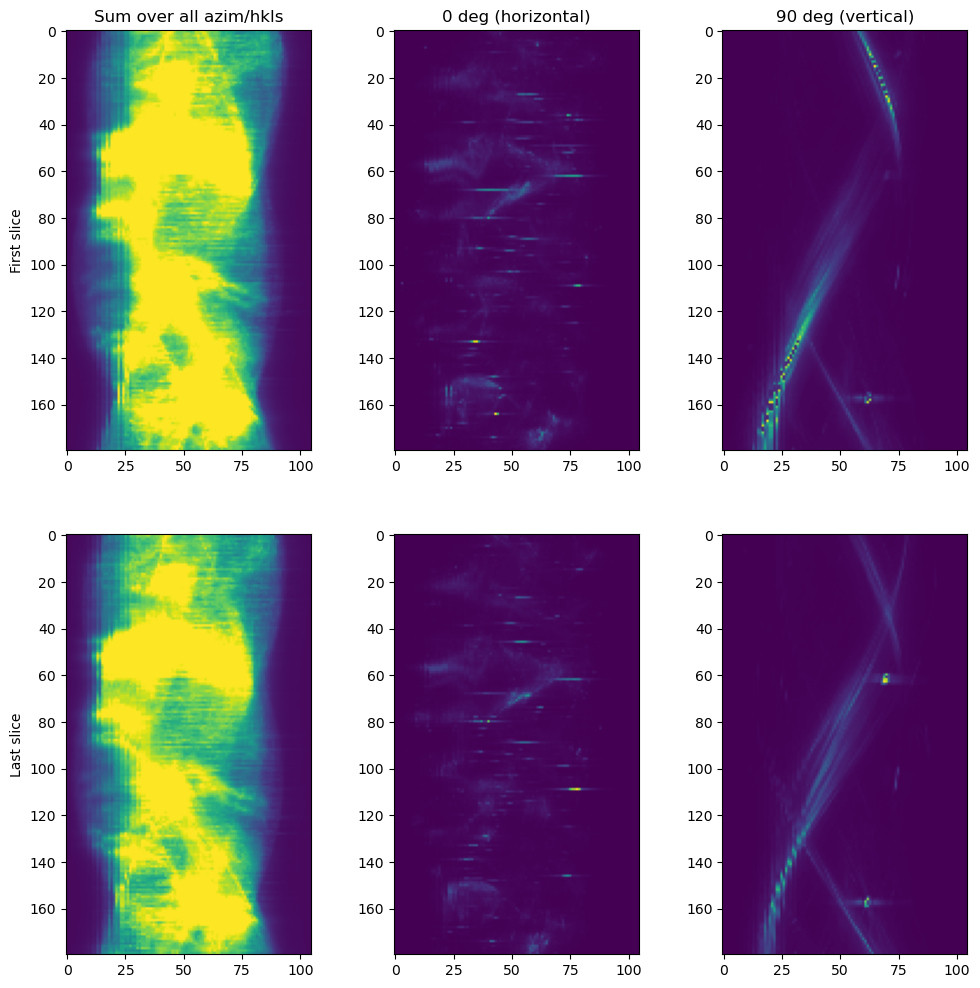

In [12]:
# %matplotlib widget
vmin = 1e2
vmax = 3e6

fig, axs = plt.subplots(2,3,figsize = (12, 12))
axs[0,0].set_title('Sum over all azim/hkls')
axs[0,0].imshow(np.sum(full_data_array[:, :, 0, :, :], axis = (2,3)), vmin = vmin, vmax = vmax)
axs[0,0].set_ylabel('First slice')

axs[0,1].set_title(f'0 deg (horizontal)')
axs[0,1].imshow(np.sum(full_data_array[:, :, 0, 0:1, :], axis = (2,3)), vmin = vmin)

axs[0,2].set_title('90 deg (vertical)')
axs[0,2].imshow(np.sum(full_data_array[:, :, 0, npt_azim//bin_factor_azim//4:npt_azim//bin_factor_azim//4+1, :], axis = (2,3)), vmin = vmin)

# axs[1,0].set_title('Sum over all azim/hkls')
axs[1,0].imshow(np.sum(full_data_array[:, :, number_of_slizes-1, :, :], axis = (2,3)), vmin = vmin, vmax = vmax)
axs[1,0].set_ylabel('Last slice')

# axs[1,1].set_title(f'0 deg (horizontal)')
axs[1,1].imshow(np.sum(full_data_array[:, :, number_of_slizes-1, 0:1, :], axis = (2,3)), vmin = vmin)

# axs[1,2].set_title('90 deg (vertical)')
axs[1,2].imshow(np.sum(full_data_array[:, :, number_of_slizes-1, npt_azim//bin_factor_azim//4:npt_azim//bin_factor_azim//4+1, :], axis = (2,3)), vmin = vmin)

plt.show()

## Save sinogram

In [13]:
fname = f'auxillary_files/{sample}_full_data_array.npy'
np.save(fname, full_data_array)
#Clear memory
del full_data_array

In [14]:
fname

'auxillary_files/textom_posth14_post_beamdown_full_data_array.npy'